# Assignment 2 of GEO1001
## Name: Pratyush
## Student Number: 5359252

#### Imports required: rasterio, matplotlib , seaborn, os, numpy, sklearn    

>You have to classify 2 resolutions:

>1. The whole **60m** image
>2. A **subset** of the **10m** (use rasterio.window)

>These 2 might require different parameters, it is up to you to tell me.

## Imports

In [1]:
import rasterio 
from rasterio import plot # for plotting datasets, may not be of use
from rasterio.plot import show_hist # for showing histogram distribution of bands in a daatset, may not be of use
from rasterio.windows import Window , from_bounds, crop# for clipping out only a window from dataset use in part 2
import matplotlib.pyplot as plt #for plotting images
import numpy as np # for doing computations
import os  # to read file paths to the image data
from sklearn import cluster
%matplotlib inline

## Read sentinel image from assignment

Table of bands and respective resolutions

| Band 	| Resolution 	| Central Wavelength 	|            Description           	|
|:----:	|:------------:	|:--------------------:	|:--------------------------------:	|
| B1   	| 60 m       	| 443 nm             	| Ultra blue (Coastal and Aerosol) 	|
| B2   	| 10 m       	| 490 nm             	| Blue                             	|
| B3   	| 10 m       	| 560 nm             	| Green                            	|
| B4   	| 10 m       	| 665 nm             	| Red                              	|
| B5   	| 20 m       	| 705 nm             	| vegetation and red edge (VNIR) 	|
| B6   	| 20 m       	| 740 nm             	| vegetation and red edge (VNIR) 	|
| B7   	| 20 m       	| 783 nm             	| vegetation and red edge (VNIR) 	|
| B8   	| 10 m       	| 842 nm             	| Near Infrared (NIR) for FCC    	|
| B8a  	| 20 m       	| 865 nm             	| Narrow Near Infrared (VNIR) 	    |
| B9   	| 60 m       	| 940 nm             	| Water Vapour                  	|
| B10  	| 60 m       	| 1375 nm            	| Short Wave Infrared (SWIR): cirrus       	|
| B11  	| 20 m       	| 1610 nm            	| Short Wave Infrared (SWIR)       	|
| B12  	| 20 m       	| 2190 nm            	| Short Wave Infrared (SWIR)       	|

path = path to all images 
stackpath = list of all paths of required bands 
ds = list of datasets for such bands

# **Part 1**
## Get 60m datasets

npa has all bands stacked as np arrays

[k-means-sentinel-2-python](http://www.acgeospatial.co.uk/k-means-sentinel-2-python/)

In [2]:
path_60 = R'./GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/R60m'
l = os.listdir(path_60)
tostack = l[1:12] #take bands 1 to 12 for 60m dataset
stackpath = [os.path.join(path_60,i) for i in tostack]
ds = [rasterio.open( stackpath[i] , driver='JP2OpenJPEG') for i in  range(len( stackpath ))] # list of datasets    

npa = np.zeros( ds[0].read(1).shape , dtype='int32')

for i in range( len(ds) ):
    if i==0:
        npa += np.array(ds[i].read(1) , dtype='int32' ) 
    else:
        npa = np.dstack((npa , np.array(ds[i].read(1) , dtype='int32' ))  )   
    ds[i].close()

del ds

#ds data is open, should close for better memory management
new_shape = (npa.shape[0] * npa.shape[1], npa.shape[2])
haha = npa[:, :, :].reshape(new_shape)
haha


array([[ 288,  289,  185, ...,   66,   61,   75],
       [ 387,  294,  192, ...,   67,   68,   81],
       [ 368,  299,  193, ...,   66,   68,   75],
       ...,
       [ 395,  513,  754, ..., 2673, 1731, 2397],
       [ 419,  415,  621, ..., 2403, 1533, 2232],
       [ 342,  621,  881, ..., 3010, 2029, 2429]], dtype=int32)

In [4]:
k_start = 5
k_end =   10

ds = rasterio.open( stackpath[0] , driver='JP2OpenJPEG')
c = ds.crs
trans = ds.transform
ds.close()
del ds

if not os.path.exists('./exports/k_means/60m'):
    os.makedirs('./exports/k_means/60m')

for i in range(  k_start  ,  k_end + 1  ):
    k_means = cluster.KMeans(n_clusters= i )
    k_means.fit(haha)

    X_cluster = k_means.labels_
    X_cluster = X_cluster.reshape(npa[:, :, 0].shape)
    
    
    save_dim = X_cluster.shape
    
    comp = rasterio.open('./exports/k_means/60m/km_60m_{}.tiff'.format(i),'w', 
                        driver='Gtiff', 
                        height = int(save_dim[0]), 
                        width = int(save_dim[1]), 
                        count= 1,
                        dtype = X_cluster.dtype, 
                        crs= c, 
                        transform = trans
                        )
    comp.write( X_cluster , 1) 
    comp.close()   


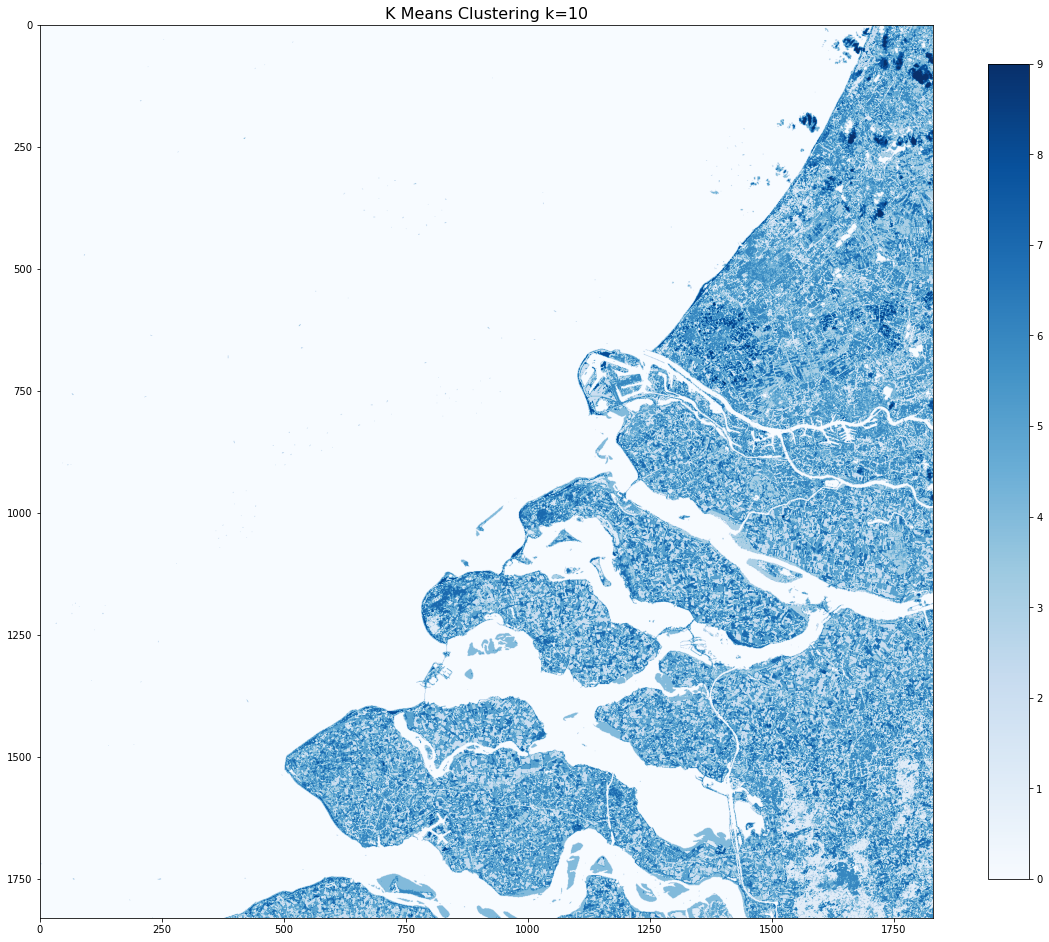

In [5]:
plt.figure(figsize=(20,20))
plt.imshow(X_cluster, cmap="Blues")
plt.colorbar(shrink=0.75)
plt.title('K Means Clustering k=10' , fontsize=16)
plt.show()

In [46]:
k_path = [os.path.join('./exports/k_means/60m' , i) for i in os.listdir('./exports/k_means/60m') if i.endswith('.tiff')]
f , axs = plt.subplots(2,3 , figsize=(22,15))
for _ in range(len(k_path)):
    filenm = k_path[_].split('/')[-1].split('_')[2].strip('.tiff')
    img = rasterio.open(k_path[_], driver='GTiff')
    if _ <3:
        axs[0][_].imshow(img.read(1) , cmap='hsv')
        axs[0][_].set_title('k= {}'.format(filenm) , fontsize='14') 
    else:
        axs[1][_ - 3].imshow(img.read(1) , cmap='hsv')
        axs[1][_ - 3].set_title('k= {}'.format(filenm) , fontsize='14')
    img.close()
    del img 
plt.suptitle('K means clustering for different k', fontsize='16')
plt.show()    


FileNotFoundError: [Errno 2] No such file or directory: './exports/k_means/60m'

## change no of band and explain how it affects

### trying to implement the data import from google cloud storage

```python
# filepath = R'https://console.cloud.google.com/storage/browser/gcp-public-data-sentinel-2/L2/tiles/31/U/ET/S2A_MSIL2A_20200530T105031_N0214_R051_T31UET_20200530T134211.SAFE/GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/R10m/'

# src = rasterio.open(filepath + 'T31UET_20200530T105031_B02_10m.jp2' , driver='JP2OpenJPEG') 
# print(src.profile)
import urllib
fp = 'https://console.cloud.google.com/storage/browser/gcp-public-data-sentinel-2/L2/tiles/31/U/ET/S2A_MSIL2A_20200530T105031_N0214_R051_T31UET_20200530T134211.SAFE/GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/R10m/T31UET_20200530T105031_B02_10m.jp2'

src = rasterio.open(fp, window=Window(100,100,700,500) )
src
```

# 10 meter dataset Sentinel 2A
## subset of 10 m datasets 
### with top left coordinate as 601200.0 , 5773695.0
### and width , height as 700,500


In [25]:
path_10 =  R'./GRANULE/L2A_T31UET_A025788_20200530T105134/IMG_DATA/R10m'
l_10 = os.listdir(path_10)
tostack_10 = l_10[1:5] #take bands B G R NIR for 10m data
stackpath_10 = [os.path.join(path_10,i) for i in tostack_10]
ds_10 = [rasterio.open( stackpath_10[i], driver='JP2OpenJPEG' ) for i in  range(len( stackpath_10 ))] # list of datasets    
r,c= ds_10[0].index( 601200.0 , 5773695.0 )

window_= Window( col_off=c , row_off= r ,width= 700,height= 500)

bands_10=  np.zeros( ds_10[0].read(1 , window=window_).shape , dtype='int32') #array holding all bands as numpy arrays 

for i in range( len(ds_10) ):
    if i==0:
        bands_10 += np.array(ds_10[i].read(1, window=window_) , dtype='int32' ) 
    else:
        bands_10 = np.dstack((bands_10 , np.array(ds_10[i].read(1, window=window_) , dtype='int32' ))  )   
    ds_10[i].close()

del ds_10

print(bands_10.shape)

new_shape = (bands_10.shape[0] * bands_10.shape[1], bands_10.shape[2])
newarr_10 = bands_10[:, :, :].reshape(new_shape)
newarr_10

(500, 700, 4)


array([[ 380,  791,  489, 4240],
       [ 316,  706,  449, 3564],
       [ 373,  771,  504, 4046],
       ...,
       [ 515,  802,  508, 4792],
       [ 515,  793,  518, 4804],
       [ 495,  767,  526, 4712]], dtype=int32)

```python
npa = np.zeros( ds[0].read(1).shape , dtype='int32')

for i in range( len(ds) ):
    if i==0:
        npa += np.array(ds[i].read(1) , dtype='int32' ) 
    else:
        npa = np.dstack((npa , np.array(ds[i].read(1) , dtype='int32' ))  )   
    ds[i].close()

del ds

#ds data is open, should close for better memory management
new_shape = (npa.shape[0] * npa.shape[1], npa.shape[2])
haha = npa[:, :, :].reshape(new_shape)
haha
```

In [26]:
k_start = 5
k_end =   10

ds = rasterio.open( stackpath[0] , driver='JP2OpenJPEG')
c = ds.crs
trans = ds.transform
ds.close()
del ds


if not os.path.exists('./exports/k_means/10m'):
    os.makedirs('./exports/k_means/10m')

for i in range(  k_start  ,  k_end + 1  ):
    k_means = cluster.KMeans(n_clusters= i )
    k_means.fit(newarr_10)

    X_cluster = k_means.labels_
    X_cluster = X_cluster.reshape(bands_10[:, :, 0].shape)
    
    
    save_dim = X_cluster.shape
    
    comp = rasterio.open('./exports/k_means/10m/km_10_{}.tiff'.format(i),'w', 
                        driver='Gtiff', 
                        height = int(save_dim[0]), 
                        width = int(save_dim[1]), 
                        count= 1,
                        dtype = X_cluster.dtype, 
                        crs= c, 
                        transform = trans
                        )
    comp.write( X_cluster , 1) 
    comp.close()   


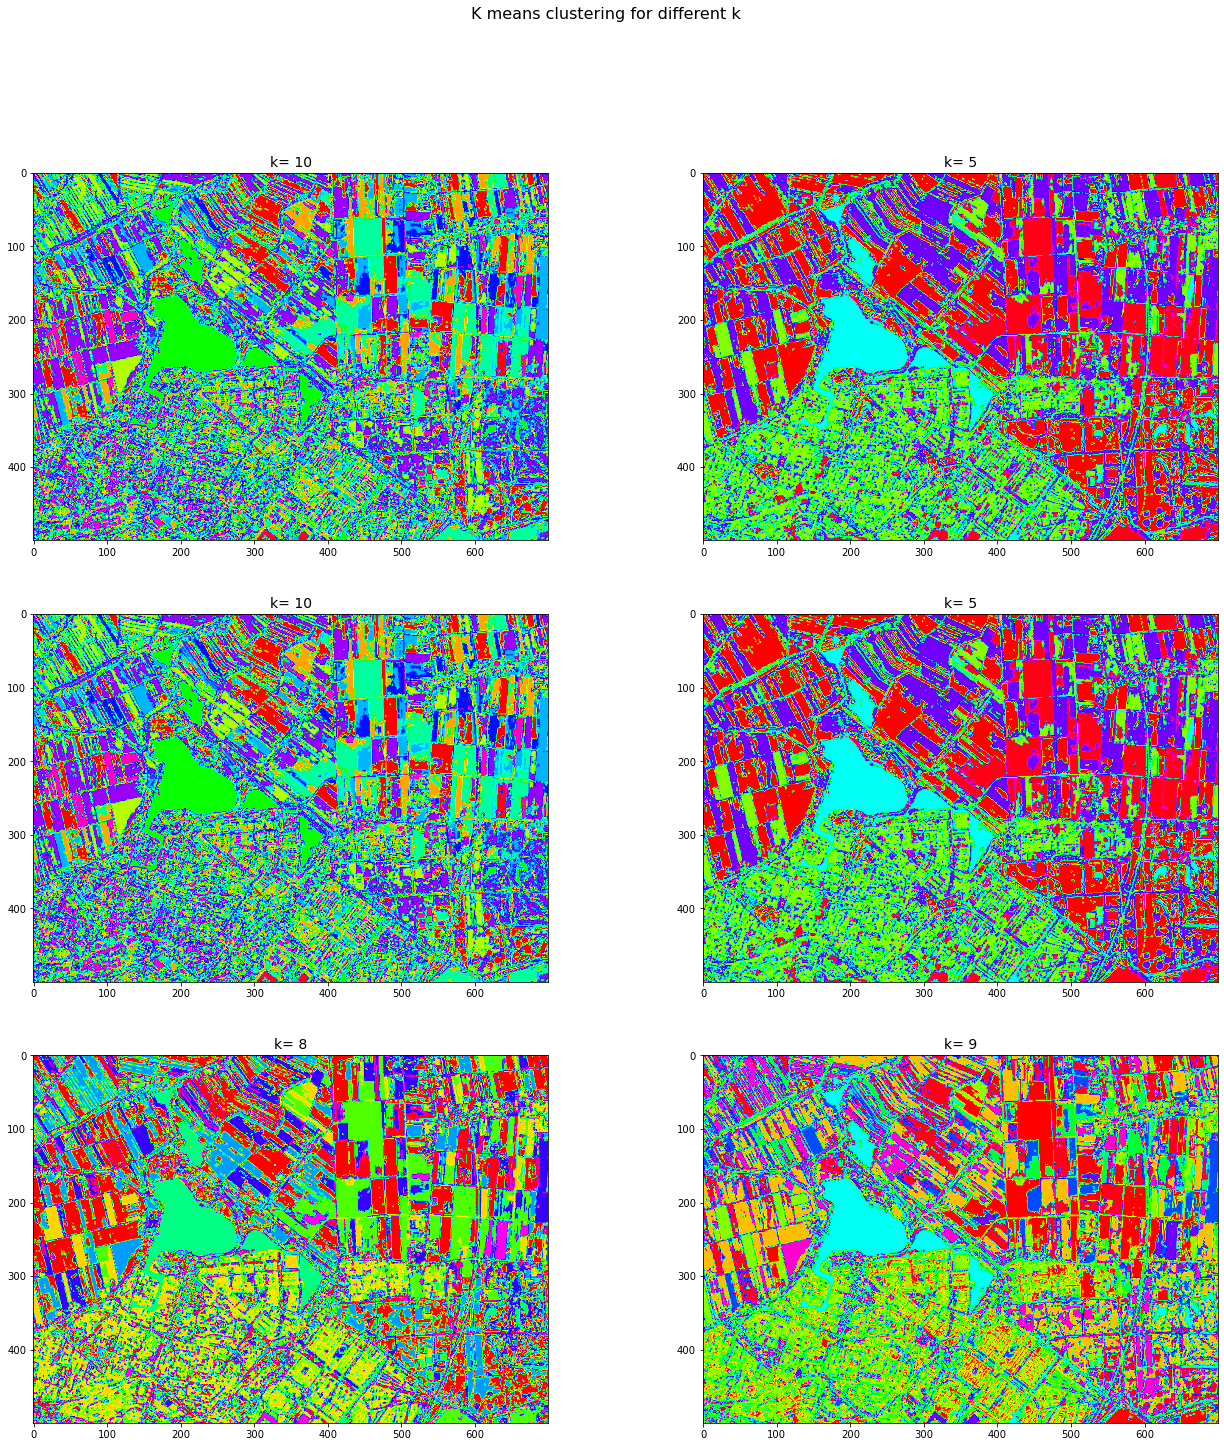

In [45]:
k_path = [os.path.join('./exports/k_means/10m' , i) for i in os.listdir('./exports/k_means/10m') if i.endswith('.tiff')]
f , axs = plt.subplots(3 , 2 , figsize=(22,23))
for _ in range(len(k_path)):
    filenm = k_path[_].split('/')[-1].split('_')[2].strip('.tiff')
    img = rasterio.open(k_path[_], driver='GTiff')
    if _ <2:
        axs[0][_].imshow(img.read(1) , cmap='hsv')
        axs[0][_].set_title('k= {}'.format(filenm) , fontsize='14') 
    # elif _>=2 & _<4:
        axs[1][_ - 2].imshow(img.read(1) , cmap='hsv')
        axs[1][_ - 2].set_title('k= {}'.format(filenm), fontsize='14' )
    else:
        axs[2][_ - 4].imshow(img.read(1) , cmap='hsv')
        axs[2][_ - 4].set_title('k= {}'.format(filenm), fontsize='14' )
    img.close()
    del img 
plt.suptitle('K means clustering for different k', fontsize='16')
plt.show()